## Introduction

Our project deals with document authorship. It is specifically curated to small documents, 
such as reviews, emails, texts, and other similar media. Larger documents are easier to 
classify because of the amount of text that lay within these documents. Smaller text 
requires a certain finesse and does not classify easily. Neural networks, by nature, 
are adept at learning sophisticated patterns unseen by human perception. We would like 
to use them in such a way to better determine authorship of these documents. Using Doc2Vec
and our own custom encoding, we hope to be able produce good accuracies when determining
who wrote an individual small document. Our own method uses Word2Vec vectors and sums them
all up. Primarily, three neural networks are used and they are small in size. For training and testing,
we normally set the number of authors to either 3 or 35. Our results show overfitting and typically are not
very high in accuracy. The highest we have acheived was 83% on our small dense network, but we could not
replicate it. The results will show training accuracy and loss and also tesing accuracy and loss.

## Preprocessing

Our data originates from plain text files in this format:

    authorID [tab] review_text

![Example RAW Data Format](format_example.PNG)

Using some of our scripts, you can easily convert any document with the afore mentioned format
to be encoded in two different ways:

    1. Our Custom Encoding
    2. Doc2Vec Encoding
    
For our custom encoding, the script can be run as follows:
    
    ./customDoc2Vec.py [input filename] [output filename]
    
For the Doc2Vec encoding:

    ./spacyDoc2Vec.py [input filename] [output filename]

The format of the resulting encoding is as follows:

    authorID [tab] word_vector

You can also reverse the sentences in a text corpus by running (it will output the same filename with 'r_' in front):

    ./reverseText.py [filename] 
    
These methods above use pretrained word vector models; to create your own you can do the following:

    ./gensimDoc2Vec.py [input filename] [output filename] [model name]

## Setup

In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from keras_tqdm import TQDMNotebookCallback
import copy
from keras import regularizers
from sklearn.utils import shuffle

/home/csci4850/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Reading Vector Data and One-Hot Creation

In [2]:
# choose file here
# options:
#   1. c_encoded.txt
#   2. c_encoded_r.txt
#   3. g_encoded.txt
#   4. g_encoded_r.txt
#   5. s_encoded.txt
#   6. s_encoded_r.txt

filename = 's_encoded.txt'

data = []                 # holds all data (i.e. encoded vectors)
unique = {}               # holds unique author IDs here
index = 0                 # used for determining which array inded will be 1 in the hot hot encoding
y_train = []              # one hots are in here  
author_reviews_count = 0
authors = 3               # number of unique authors to read data from

with open(filename) as file:
    for line in file:
        author = line.split('\t')[0].rstrip('\n')
        r = line.split('\t')[1].rstrip('\n')[1:-1].split(',')
        vector = [float(x.strip(',')) for x in r if x != '']
        
        if author not in unique:
            if len(unique) == authors:
                break
            unique[author] = np.zeros(authors)
            unique[author][index] = 1
            index += 1

        if len(vector) == 300:
            data.append(vector)
            y_train.append(unique[author])

## Seperate Training/Test Sets

In [3]:
x_tr = []
y_tr = []
x_te = []
y_te = []

cur = y_train[0]
count = 0
for i in range(len(data)):
    if (y_train[i] == cur).all():
        # training set
        if count < 4:
            x_tr.append(data[i])
            y_tr.append(y_train[i])
        # test set
        else:
            x_te.append(data[i])
            y_te.append(y_train[i])

    else:
        cur = y_train[i]
        count = 0
        # training set
        if count < 4:
            x_tr.append(data[i])
            y_tr.append(y_train[i])
        # test set
        else:
            x_te.append(data[i])
            y_te.append(y_train[i])
    count += 1
        

## Oversampling Option

In [4]:
'''
x1 = copy.deepcopy(x_tr)
y1 = copy.deepcopy(y_tr)
for x in range(2):
    for i in x1:
        x_tr.append(i)
    for i in y1:
        y_tr.append(i)
'''
print(len(x_tr)) # x training set size
print(len(y_tr)) # y training set size
print(len(x_te)) # x testing set size
print(len(y_te)) # y testing set size

12
12
10
10


## Shuffle and Reshape

In [5]:
x_training,y_training = shuffle(x_tr,y_tr, random_state=0) # shuffle training data
# ========================================================
x_training = np.array(x_tr)
print(x_training.shape)
# convert the 2d to 3d representation
x_training = x_training.reshape(x_training.shape + (1,))
print(x_training.shape)
output_shape = x_training.shape[1]
input_shape = x_training.shape[2]
y_training = np.array(y_tr)
print('X_training shape: ' + str(x_training.shape))
# ========================================================
print(x_training.shape)
print(y_training.shape)
x_te = np.array(x_te)
# convert the 2d to 3d representation
x_te = x_te.reshape(x_te.shape + (1,))
print('X_testing shape: ' + str(x_te.shape))
print(x_te.shape)
y_te = np.array(y_te)
print(y_te.shape)
# ========================================================

(12, 300)
(12, 300, 1)
X_training shape: (12, 300, 1)
(12, 300, 1)
(12, 3)
X_testing shape: (10, 300, 1)
(10, 300, 1)
(10, 3)


## Network 1

In [6]:
model_n1 = keras.Sequential()

model_n1.add(keras.layers.Conv1D(300, kernel_size=(3),strides=(1),
                 activation='relu',
                 kernel_regularizer=regularizers.l2(0.01),
                 activity_regularizer=regularizers.l1(0.01),
                 input_shape=[output_shape,
                              input_shape]))
model_n1.add(keras.layers.MaxPooling1D())
model_n1.add(keras.layers.Flatten())
model_n1.add(keras.layers.Dense(300, activation='relu'))
model_n1.add(keras.layers.Dense(y_training.shape[1], activation='softmax'))
#sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_n1.compile(loss=keras.losses.categorical_crossentropy,
    #optimizer = sgd,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'])

model_n1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 298, 300)          1200      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 149, 300)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 44700)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               13410300  
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 903       
Total params: 13,412,403
Trainable params: 13,412,403
Non-trainable params: 0
_________________________________________________________________


## Network 2

In [7]:
model_n2 = keras.Sequential()

model_n2.add(keras.layers.Conv1D(300, kernel_size=(3),strides=(1),
                 activation='relu',
                 input_shape=[output_shape,
                              input_shape]))
model_n2.add(keras.layers.MaxPooling1D())
model_n2.add(keras.layers.Flatten())
model_n2.add(keras.layers.Dense(300, activation='relu'))
model_n2.add(keras.layers.Dense(y_training.shape[1], activation='softmax'))
#sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_n2.compile(loss=keras.losses.categorical_crossentropy,
    #optimizer = sgd,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'])

model_n2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 298, 300)          1200      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 149, 300)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 44700)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               13410300  
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 903       
Total params: 13,412,403
Trainable params: 13,412,403
Non-trainable params: 0
_________________________________________________________________


## Network 3

In [8]:
model_n3 = keras.Sequential()

model_n3.add(keras.layers.Dense(300,
                             activation='relu',
                             input_shape=[output_shape,input_shape]))
model_n3.add(keras.layers.Flatten())
model_n3.add(keras.layers.Dense(y_training.shape[1], activation='softmax'))
#sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_n3.compile(loss=keras.losses.categorical_crossentropy,
    #optimizer = sgd,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'])

model_n3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 300, 300)          600       
_________________________________________________________________
flatten_3 (Flatten)          (None, 90000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 270003    
Total params: 270,603
Trainable params: 270,603
Non-trainable params: 0
_________________________________________________________________


## Training

In [9]:
# choose model here ...
current_model = model_n2

batch_size = 5
epochs = 5
history = current_model.fit(x_training, y_training,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    shuffle=True,
    callbacks=[TQDMNotebookCallback()],
    validation_split = 0.2)

HBox(children=(IntProgress(value=0, description='Training', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=9), HTML(value='')))

## Testing

In [10]:
score = current_model.evaluate(x_te, y_te, verbose=1)
preds = current_model.predict_on_batch(x_training)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10/10 [==============================] - 0s 7ms/step
Test loss: 12.894475936889648
Test accuracy: 0.20000000298023224


## Graphing

10/10 [==============================] - 0s 27ms/step
Test loss: 6.447237968444824
Test accuracy: 0.6000000238418579


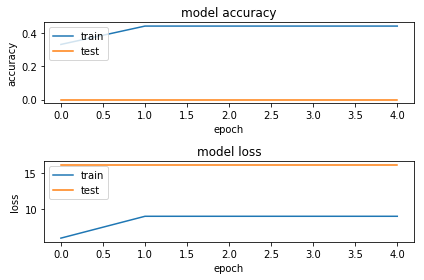

In [11]:
score = current_model.evaluate(x_te, y_te, verbose=1)
preds = current_model.predict_on_batch(x_te)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout()
plt.show()

## Predictions

In [12]:
def get_auth(l):
    #l = list(l)
    for i in unique:
        if (unique[i] == l).all():
            return i


index = 0
incorrect = 0
correct = 0
for i in range(len(preds)):
    m = max(preds[i])
    index = list(preds[i]).index(m)
    l = np.zeros(authors)
    l[index] = 1

    print(preds[i],index,y_te[i],'Guessed:',get_auth(l),'Actual:',get_auth(y_te[i]),end=' ')
    if y_te[i][index] == 1:
        print('Correct')
        correct += 1
    else:
        print('Incorrect')
        incorrect += 1

print('Correct:',correct,'Incorrect:',incorrect,'Out of:',(correct+incorrect))

[0. 1. 0.] 1 [1. 0. 0.] Guessed: AA7C90J3I44Q9 Actual: AA5KIZVGT7IOV Incorrect
[0. 1. 0.] 1 [1. 0. 0.] Guessed: AA7C90J3I44Q9 Actual: AA5KIZVGT7IOV Incorrect
[0. 1. 0.] 1 [0. 1. 0.] Guessed: AA7C90J3I44Q9 Actual: AA7C90J3I44Q9 Correct
[0. 1. 0.] 1 [0. 1. 0.] Guessed: AA7C90J3I44Q9 Actual: AA7C90J3I44Q9 Correct
[0. 1. 0.] 1 [0. 1. 0.] Guessed: AA7C90J3I44Q9 Actual: AA7C90J3I44Q9 Correct
[0. 1. 0.] 1 [0. 1. 0.] Guessed: AA7C90J3I44Q9 Actual: AA7C90J3I44Q9 Correct
[0. 1. 0.] 1 [0. 1. 0.] Guessed: AA7C90J3I44Q9 Actual: AA7C90J3I44Q9 Correct
[0. 1. 0.] 1 [0. 1. 0.] Guessed: AA7C90J3I44Q9 Actual: AA7C90J3I44Q9 Correct
[0. 1. 0.] 1 [0. 0. 1.] Guessed: AA7C90J3I44Q9 Actual: AA7P2NEC94K79 Incorrect
[0. 1. 0.] 1 [0. 0. 1.] Guessed: AA7C90J3I44Q9 Actual: AA7P2NEC94K79 Incorrect
Correct: 6 Incorrect: 4 Out of: 10
